# transformers

credits: http://nlp.seas.harvard.edu/2018/04/03/attention.html

In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [85]:
class EncoderDecoder(nn.Module):
    "Standard Enc-Dec module"
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Process masked src and target sequences"
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [86]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [87]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [88]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [89]:
class LayerNorm(nn.Module):
    "nomalization layer module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, deepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2  # z-score + bias

In [90]:
class SublayerConnection(nn.Module):
    """
    add dropout to norm
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        "apply residual connection to any sublayer with the same size"
        return x + self.dropout(sublayer(self.norm(x)))

In [91]:
class EncoderLayer(nn.Module):
    "Encoder consists of self attention and feed forward network"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        "Attention, Norm, FF, Norm"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self. sublayer[1](x, self.feed_forward)

In [92]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [93]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Self-Attention, Norm, Src-Attention, Norm, FF, Norm"
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, x, x, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [94]:
def subsequent_mask(size):
    "Mask out subsequent position."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [95]:
subsequent_mask(20)[0][0]

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

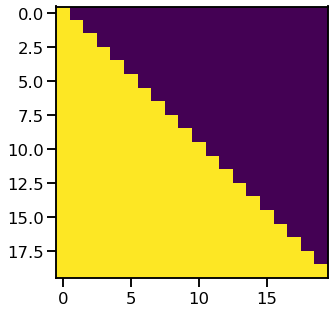

In [96]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

In [97]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [98]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads h"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v (value dimension) always equals d_k (key dimension)
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask is applied to all h heads
            mask = mask.unsqueeze(1)  # https://pytorch.org/docs/stable/generated/torch.unsqueeze.html#torch.unsqueeze
            nbatches = query.size(0)

            # 1) Do all the linear projections in batch from d_model -> h x d_k
            query, key, value = \
                [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                 for l, x in zip(self.linears, (query, key, value))]

            # 2) Apply attention on all the projected vectors in batch
            x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

            # 3) 'Concat' using a view and apply a final linear.
            # https://stackoverflow.com/questions/48915810/pytorch-what-does-contiguous-do
            # https://pytorch.org/docs/stable/tensor_view.html
            x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
            return self.linears[-1](x)

In [99]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(F.relu(self.w_1(x))))

In [100]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [101]:
class PositionalEncoding(nn.Module):
    "Implement PE function"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        "Compute the positional encodings once in log space"
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

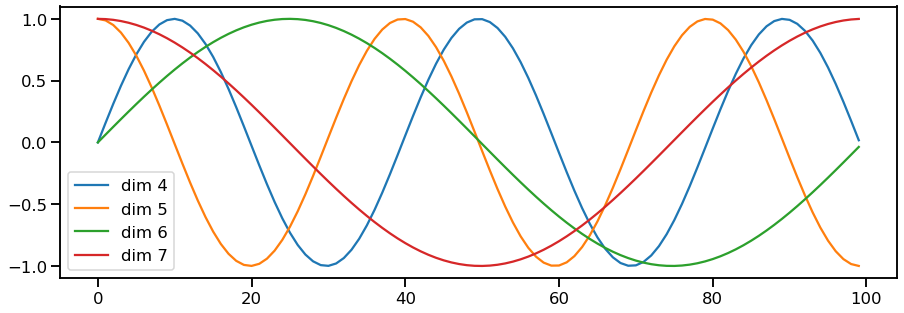

In [102]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [103]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model form given hyperparameters"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # Initialize parameters with Glorot / fan_avg
    for p in model.parameters():
        if p.dim() > 1:
           nn.init.xavier_uniform_(p)

    return model

In [104]:
# Small example model
tmp_model = make_model(10, 10, 2)

In [105]:
class Batch:
    """Object for holding a batch of data with mask during training."""
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """Create a mask to hide padding and future words."""
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [106]:
def run_epoch(data_iter, model, loss_compute):
    """Standard training and logging function"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time - start
            print("Epoch step: %d Loss: %f Tokens per sec: %f" % (i, loss / batch.ntokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens